# RL-Navigator: Autonomous Taxi Optimization

### <mark> Using Q Learning <mark>

In [2]:
pip install gymnasium

In [ ]:
import gymnasium as gym
import numpy as np
import gym
import matplotlib.pyplot as plt


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
env=gym.make("Taxi-v3")

/usr/local/lib/python3.12/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.12/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
env.reset()

428

In [ ]:

img=env.render(mode="rgb_array")

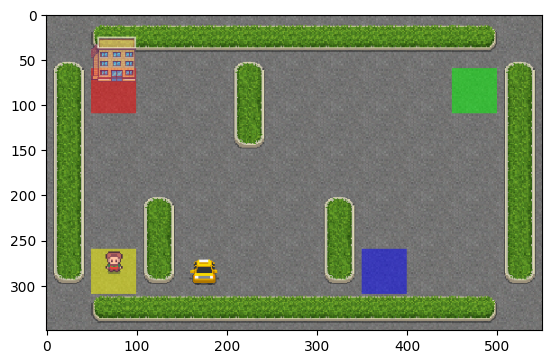

In [ ]:

plt.imshow(img)
plt.show()

In [ ]:

n_states=env.observation_space.n
n_actions=env.action_space.n
n_states,n_actions

(500, 6)

In [ ]:
Q=np.zeros([n_states,n_actions])


In [ ]:
Q

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [ ]:
G=0 #for sum of rewards
alpha=0.6

In [ ]:
for episode in range(1,2):
  done=False
  G,reward=0,0
  state=env.reset()
  while reward!=20:
    action=np.argmax(Q[state])
    state2,reward,done,info=env.step(action)
    Q[state,action]+=alpha*(reward+np.max(Q[state2])-Q[state,action])
    G+=reward
    state=state2

print("all reward {}".format(G))



all reward -2212


In [ ]:
Q

array([[ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [-1.8  , -1.8  , -1.56 , -1.8  , -1.584, -6.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       ...,
       [-1.2  , -1.2  , -0.6  , -0.6  , -6.   , -6.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ]])

In [ ]:
episodes=3000
Q=np.zeros([n_states,n_actions])

In [ ]:
for episode in range(1,episodes+1):
  done=False
  G,reward=0,0
  state=env.reset()
  while reward!=20:
    action=np.argmax(Q[state])
    state2,reward,done,info=env.step(action)
    Q[state,action]+=alpha*(reward+np.max(Q[state2])-Q[state,action])
    G+=reward
    state=state2
  if episode%100==0:
    print("episode:{} sum of reward:{}".format(episode,G))



episode:100 sum of reward:-155
episode:200 sum of reward:1
episode:300 sum of reward:8
episode:400 sum of reward:7
episode:500 sum of reward:9
episode:600 sum of reward:9
episode:700 sum of reward:9
episode:800 sum of reward:6
episode:900 sum of reward:9
episode:1000 sum of reward:15
episode:1100 sum of reward:6
episode:1200 sum of reward:9
episode:1300 sum of reward:8
episode:1400 sum of reward:6
episode:1500 sum of reward:4
episode:1600 sum of reward:14
episode:1700 sum of reward:7
episode:1800 sum of reward:10
episode:1900 sum of reward:7
episode:2000 sum of reward:6
episode:2100 sum of reward:7
episode:2200 sum of reward:8
episode:2300 sum of reward:8
episode:2400 sum of reward:7
episode:2500 sum of reward:10
episode:2600 sum of reward:12
episode:2700 sum of reward:5
episode:2800 sum of reward:4
episode:2900 sum of reward:4
episode:3000 sum of reward:9


In [ ]:
actions={
          0:"South",
          1:"North",
          2:"East",
          3:"West",
          4:"Pick Up",
          5:"Drop off"
}

In [ ]:

state=env.reset()
done=None


In [ ]:
while done!=True:
  action=np.argmax(Q[state])
  state,reward,done,info=env.step(action)
  output=actions.get(action)
  print("\n",f"{output}")
  img=env.render(mode="rgb_array")
  plt.imshow(img)
  plt.show()


Output hidden; open in https://colab.research.google.com to view.

### <mark> Using Deep Q Learning <amrk>

https://docs.pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [2]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("Taxi-v3")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [3]:
device = "cpu"

In [4]:
n_states=env.observation_space.n
n_actions=env.action_space.n
n_states,n_actions

(np.int64(500), np.int64(6))

`Transition` - a named tuple representing a single transition in our environment. It essentially maps (state, action) pairs to their (next_state, reward) result, with the state being the screen difference image as described later on.

`ReplayMemory` - a cyclic buffer of bounded size that holds the transitions observed recently. It also implements a `.sample()` method for selecting a random batch of transitions for training.

In [5]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [6]:
# class DQN(nn.Module):

#     def __init__(self, n_observations, n_actions):
#         super(DQN, self).__init__()
#         self.layer1 = nn.Linear(n_observations, 128)
#         self.layer2 = nn.Linear(128, 128)
#         self.layer3 = nn.Linear(128, n_actions)

#     # Called with either one element to determine next action, or a batch
#     # during optimization. Returns tensor([[left0exp,right0exp]...]).
#     def forward(self, x):
#         x = F.relu(self.layer1(x))
#         x = F.relu(self.layer2(x))
#         return self.layer3(x)

In [7]:
import torch
import torch.nn as nn

class DQN(nn.Module):
    def __init__(self, num_states=500, embed_dim=64, num_actions=6):
        super(DQN, self).__init__()
        # Embedding layer: maps state id -> dense vector
        self.embedding = nn.Embedding(num_states, embed_dim)

        # Hidden layers
        self.fc1 = nn.Linear(embed_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)

        # Output layer: Q-values for each action
        self.fc_out = nn.Linear(64, num_actions)

    def forward(self, state_id):
        # state_id is an integer tensor (state indices)
        x = self.embedding(state_id)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        q_values = self.fc_out(x)  #last network
        return q_values

In [8]:
import random

# Hyperparameters
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.1
epsilon_decay = 0.999
lr = 0.001

# Initialize network + optimizer
policy_net = DQN()
optimizer = optim.Adam(policy_net.parameters(), lr=lr)
# loss_fn = nn.MSELoss()
loss_fn = nn.SmoothL1Loss()   #Huber loss, MSE at small errors, and MAE at large errors

# Replay buffer
# memory = []
memory = ReplayMemory(50000)


def select_action(state):
    if random.random() < epsilon:
        return env.action_space.sample()  # explore
    else:
        state_tensor = torch.tensor([state], dtype=torch.long)
        with torch.no_grad():
            q_values = policy_net(state_tensor)
        return torch.argmax(q_values).item()


# Target network
target_net = DQN()
target_net.load_state_dict(policy_net.state_dict())   #the target_net (target network) is updated with the weights (or parameters) of the policy_net (policy network). This is done periodically to stabilize the learning process. The policy network learns and updates its Q-values more frequently, while the target network provides a stable target for these Q-value updates, preventing oscillations and improving convergence.
target_net.eval()

update_target_every = 1000
steps_done = 0

for episode in range(20000):  # more episodes
    state, info = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = select_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        memory.push(state, action, next_state, reward, done)

        if len(memory) > 1000:  # warmup
            batch = memory.sample(64)
            states, actions, next_states, rewards, dones = zip(*batch)

            states = torch.tensor(states, dtype=torch.long)
            actions = torch.tensor(actions, dtype=torch.long)
            rewards = torch.tensor(rewards, dtype=torch.float32)
            next_states = torch.tensor(next_states, dtype=torch.long)
            dones = torch.tensor(dones, dtype=torch.float32)

            q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze()

            with torch.no_grad():
                next_q_values = target_net(next_states).max(1)[0]
                targets = rewards + gamma * next_q_values * (1 - dones)

            loss = loss_fn(q_values, targets)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)   #prevent exploding gradients
            optimizer.step()

            steps_done += 1
            if steps_done % update_target_every == 0:
                target_net.load_state_dict(policy_net.state_dict())  # update the target net, the stable network

        state = next_state
        total_reward += reward

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    if episode % 100 == 0:
        print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {epsilon:.3f}")

Episode 0, Total Reward: -785, Epsilon: 0.999
Episode 100, Total Reward: -659, Epsilon: 0.904
Episode 200, Total Reward: -474, Epsilon: 0.818
Episode 300, Total Reward: -245, Epsilon: 0.740
Episode 400, Total Reward: -179, Epsilon: 0.670
Episode 500, Total Reward: -51, Epsilon: 0.606
Episode 600, Total Reward: -25, Epsilon: 0.548
Episode 700, Total Reward: -31, Epsilon: 0.496
Episode 800, Total Reward: 7, Epsilon: 0.449
Episode 900, Total Reward: -31, Epsilon: 0.406
Episode 1000, Total Reward: -101, Epsilon: 0.367
Episode 1100, Total Reward: 5, Epsilon: 0.332
Episode 1200, Total Reward: -10, Epsilon: 0.301
Episode 1300, Total Reward: -16, Epsilon: 0.272
Episode 1400, Total Reward: -14, Epsilon: 0.246
Episode 1500, Total Reward: -2, Epsilon: 0.223
Episode 1600, Total Reward: -8, Epsilon: 0.202
Episode 1700, Total Reward: -9, Epsilon: 0.182
Episode 1800, Total Reward: 3, Epsilon: 0.165
Episode 1900, Total Reward: -7, Epsilon: 0.149
Episode 2000, Total Reward: -1, Epsilon: 0.135
Episode 2

In [9]:
import torch

model_filename = 'dqn_taxi_v3_policy_net.pth'

# Save the state dictionary of the policy network
torch.save(policy_net.state_dict(), model_filename)

print(f"Trained policy network saved to {model_filename}")

Trained policy network saved to dqn_taxi_v3_policy_net.pth


In [10]:
actions={
          0:"South",
          1:"North",
          2:"East",
          3:"West",
          4:"Pick Up",
          5:"Drop off"
}


 North


C:\Users\KIIT\AppData\Roaming\Python\Python312\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


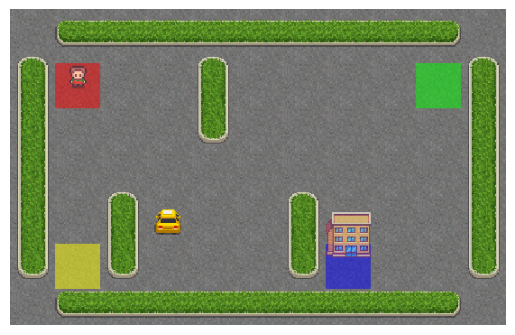


 North


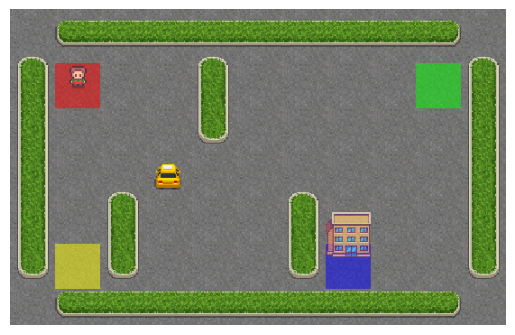


 North


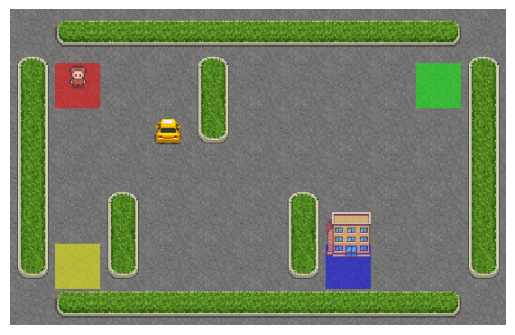


 North


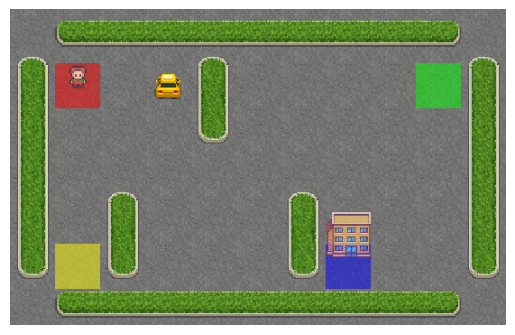


 West


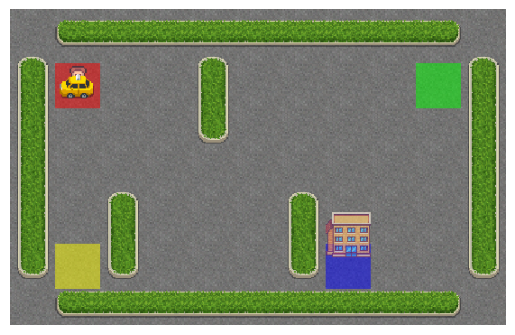


 Pick Up


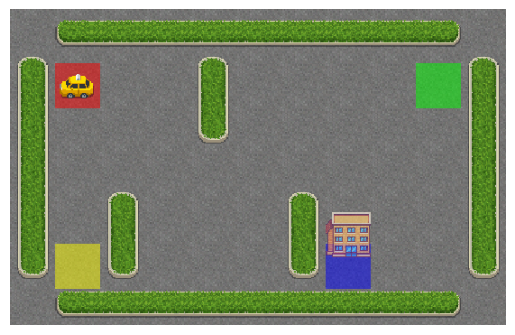


 East


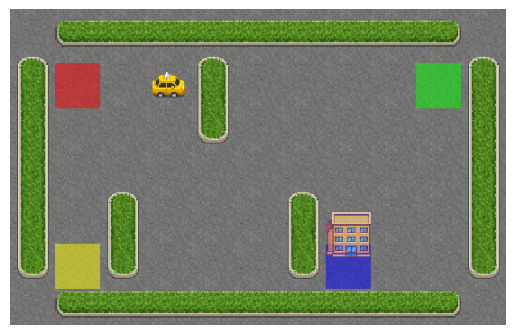


 South


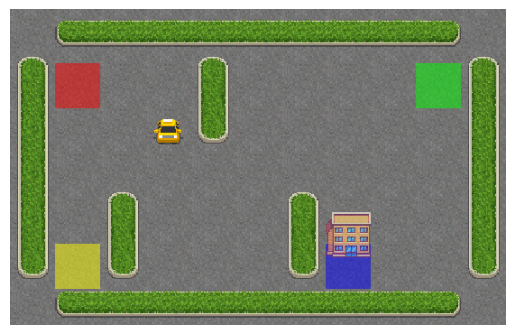


 South


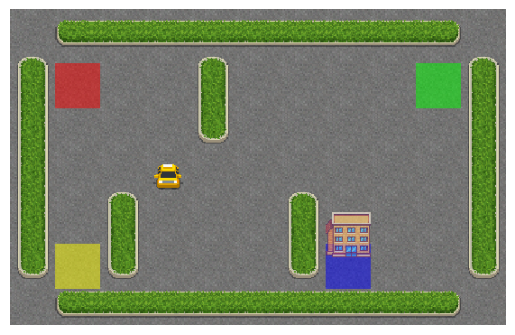


 East


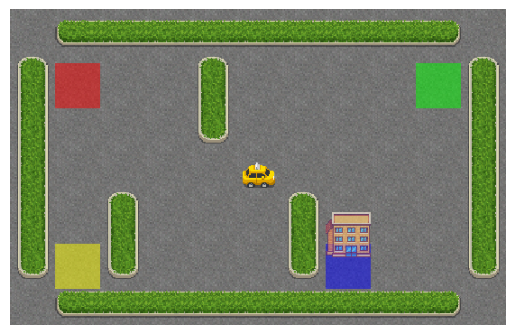


 East


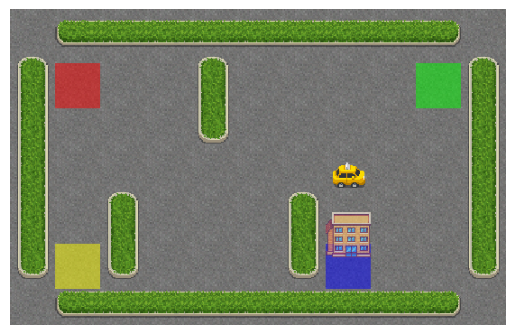


 South


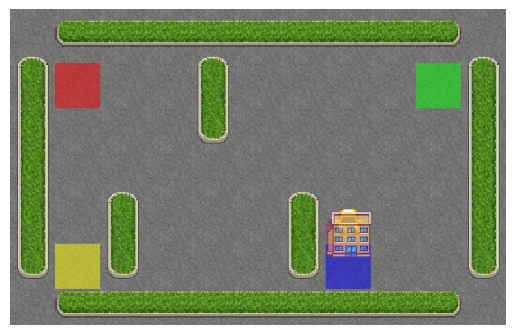


 South


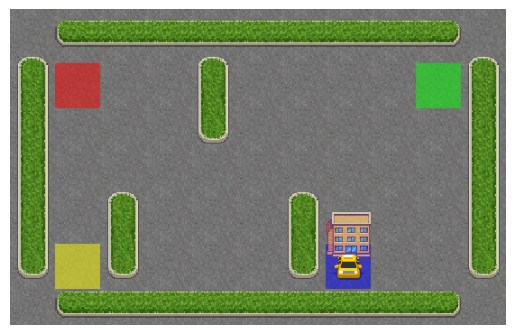


 Drop off


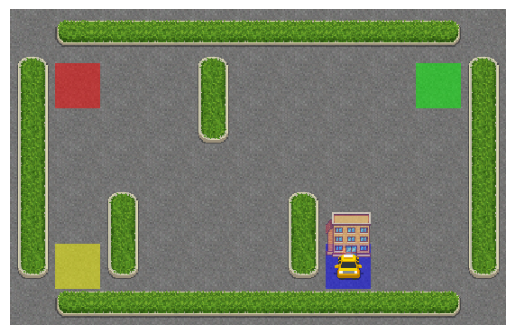

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym

env = gym.make("Taxi-v3", render_mode="rgb_array")

state, info = env.reset()
done = False

while not done:
    #conevrt state to embedding
    state_tensor = torch.tensor([state], dtype=torch.long)

    # Greedy action from DQN
    with torch.no_grad():
        q_values = policy_net(state_tensor)
        action = torch.argmax(q_values).item()

    # Step in environment
    next_state, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # Print action name (assuming you have a dict mapping)
    output = actions.get(action)
    print("\n", f"{output}")

    # Render frame
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    plt.show()

    # Move to next state
    state = next_state

env.close()